<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [374]:
import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

In [375]:
# Parameter for data
## Security code
stock_code='GGB'
## Start Date
start_date='2015-08-17'
## End Date
end_date='2023-07-28'
## Split ratio of train data and validation data
train_rate=0.8
## How many business days to see
observation_period_num=60
## How many business days to predict
predict_period_num=1

# Parameter for mdoel
## Learning Rate
lr=0.00005
## Epoch Number
epochs=100
## Mini-Batch size
batch_size=20
## How many epochs to stop train if valid loss is not decreasing
patience=20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [376]:
# Normalization
mean_list=df.mean().values
std_list=df.std().values
df=(df-mean_list)/std_list
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-17,-1.764069,-1.757158,-1.731150,-1.738618,-1.534867,-1.331972
2015-08-18,-1.748995,-1.764625,-1.731150,-1.761223,-1.551100,-0.910641
2015-08-19,-1.771606,-1.794491,-1.784442,-1.806431,-1.583565,-1.209294
2015-08-20,-1.809288,-1.824357,-1.799668,-1.806431,-1.583565,-1.173303
2015-08-21,-1.846971,-1.876624,-1.837734,-1.866709,-1.626853,-0.873031
...,...,...,...,...,...,...
2023-07-21,1.501907,1.449363,1.527674,1.496034,2.199316,-1.015928
2023-07-24,1.541474,1.629681,1.607612,1.685909,2.395513,-0.542547
2023-07-25,1.802617,1.802158,1.863415,1.820404,2.534486,0.084012


In [377]:
# Array initialization
inout_data=[]

# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
  data=df.iloc[i:i+observation_period_num,4].values
  label=df.iloc[i+predict_period_num:i+observation_period_num+predict_period_num,4].values
  inout_data.append((data,label))
inout_data=torch.FloatTensor(inout_data)

train_data=inout_data[:int(np.shape(inout_data)[0]*train_rate)].to(device)
valid_data=inout_data[int(np.shape(inout_data)[0]*train_rate):].to(device)

print('train data：',np.shape(train_data)[0])
print('valid data：',np.shape(valid_data)[0])

train data： 1551
valid data： 388


In [378]:
# Define a function for getting mini-batch
def get_batch(source, i, batch_size):
  seq_len=min(batch_size, len(source)-1-i)
  data=source[i:i+seq_len]
  input=torch.stack(torch.stack([item[0] for item in data]).chunk(observation_period_num,1))
  target=torch.stack(torch.stack([item[1] for item in data]).chunk(observation_period_num,1))

  return input, target

In [379]:
# Functions for positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len=5000):
    super().__init__()
    self.dropout=nn.Dropout(p=0.1)
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0)/d_model))
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)
    pe=pe.unsqueeze(0).transpose(0,1)
    self.register_buffer("pe",pe)

  def forward(self,x):
    return self.dropout(x+self.pe[:np.shape(x)[0],:])

In [380]:
# Transformer model definition
class TransformerModel(nn.Module):
  def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
    super().__init__()
    self.model_type='Transformer'
    self.src_mask=None
    self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.pos_encoder=PositionalEncoding(d_model=feature_size)
    self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=10,dropout=dropout)
    self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
    self.decoder=nn.Linear(feature_size,1)

  def init_weights(self):
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform(-0.1,0.1)

  def _generate_square_subsequent_mask(self,sz):
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

  def forward(self,src):
    if self.src_mask is None or self.src_mask.size(0)!=len(src):
      device=self.device
      mask=self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask=mask
    src=self.pos_encoder(src)
    output=self.transformer_encoder(src,self.src_mask)
    output=self.decoder(output)
    return output

In [381]:
# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf

    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score==self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

 10:epoch | 0.002488294 : train loss | 0.1012712 : valid loss
 20:epoch | 0.001481191 : train loss | 0.07672565 : valid loss
 30:epoch | 0.001206729 : train loss | 0.06894835 : valid loss
 40:epoch | 0.001083175 : train loss | 0.06496822 : valid loss
 50:epoch | 0.001016929 : train loss | 0.06454351 : valid loss
 60:epoch | 0.0009735327 : train loss | 0.06332797 : valid loss
 70:epoch | 0.0009340244 : train loss | 0.06395131 : valid loss
 80:epoch | 0.0009221804 : train loss | 0.0631976 : valid loss
 90:epoch | 0.0009088198 : train loss | 0.06477046 : valid loss
100:epoch | 0.0009118273 : train loss | 0.06472793 : valid loss


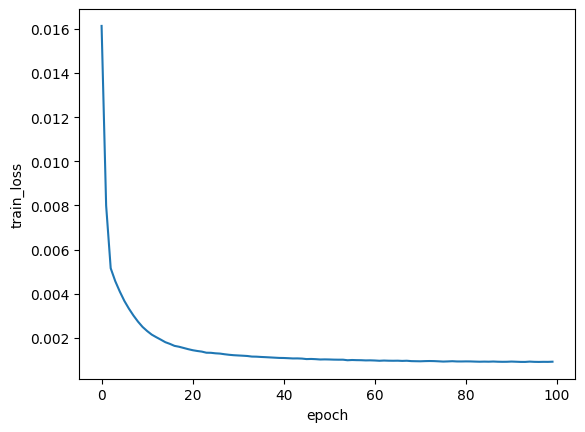

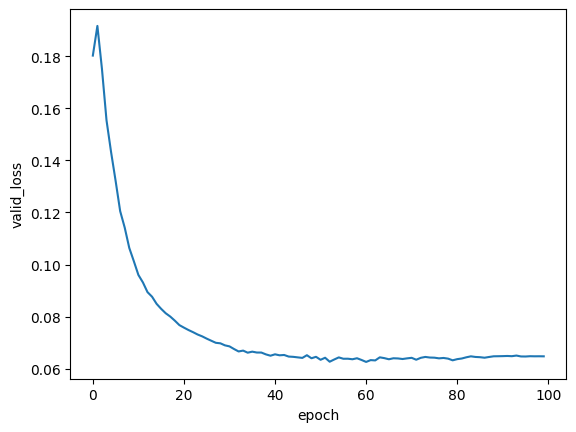

In [382]:
model=TransformerModel().to(device)
criterion=nn.MSELoss()

optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.95)
earlystopping=EarlyStopping(patience)

train_loss_list=[]
valid_loss_list=[]

for epoch in range(1,epochs+1):
  # train
  model.train()
  total_loss_train=0.0
  for batch, i in enumerate(range(0,len(train_data),batch_size)):
    data,targets=get_batch(train_data,i,batch_size)
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,targets)
    loss.backward()
    optimizer.step()
    total_loss_train+=loss.item()
  scheduler.step()
  total_loss_train=total_loss_train/len(train_data)

  #valid
  model.eval()
  total_loss_valid=0.0
  for i in range(0,len(valid_data),batch_size):
    data,targets=get_batch(valid_data,i,batch_size)
    output=model(data)
    total_loss_valid+=len(data[0])*criterion(output, targets).cpu().item()
  total_loss_valid=total_loss_valid/len(valid_data)

  #etc
  train_loss_list.append(total_loss_train)
  valid_loss_list.append(total_loss_valid)
  if epoch%10==0:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
  earlystopping((total_loss_valid),model)
  if earlystopping.early_stop:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    print("Early Stop")
    break

plt.xlabel('epoch')
plt.ylabel(R'train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

In [383]:
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)

with torch.no_grad():
  for i in range(0,len(valid_data)-1):
    data,target=get_batch(valid_data,i,1)
    output=model(data)
    result=torch.cat((result, output[-1].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-1].view(-1).cpu()),0)



import matplotlib.pyplot as pyplot
fig = pyplot.figure(1, figsize=(20, 5))
fig.patch.set_facecolor('xkcd:white')
pyplot.plot([k + 160 for k in range(238)],result[160:],color="red")
pyplot.title('Transformer Single variable')
pyplot.plot(actual[:700],color="black")
pyplot.legend(["prediction", "true"], loc="upper left")
ymin, ymax = pyplot.ylim()
pyplot.vlines(160, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
pyplot.ylim(ymin, ymax)
pyplot.xlabel("Periods")
pyplot.ylabel("Price")
pyplot.show()
pyplot.close()

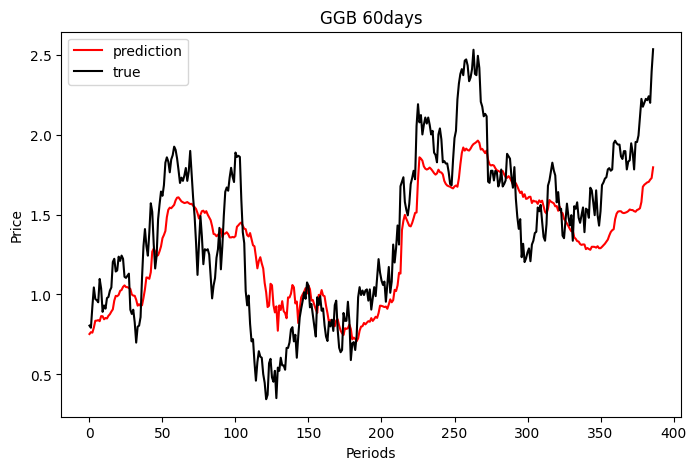

In [384]:
import pandas as pd


result = np.array(result)
result = pd.DataFrame(result)
actual = np.array(actual)
actual = pd.DataFrame(actual)

import matplotlib.pyplot as pyplot
fig = pyplot.figure(1, figsize=(8, 5))
fig.patch.set_facecolor('xkcd:white')
pyplot.plot(result,color="red")
pyplot.title('GGB 60days')
pyplot.plot(actual,color="black")
pyplot.legend(["prediction", "true"], loc="upper left")
ymin, ymax = pyplot.ylim()
#pyplot.vlines(250, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
pyplot.ylim(ymin, ymax)
pyplot.xlabel("Periods")
pyplot.ylabel("Price")
pyplot.show()
pyplot.close()

In [385]:
from sklearn import metrics

print(metrics.mean_squared_error(actual, result))
print(metrics.mean_absolute_error(actual, result))

print(metrics.r2_score(actual, result))

0.08656003
0.24247785
0.6576723103331321
